In [1]:
path = "./data/Benchmark/"
path_to_att_sbm = "./AttributedSBM/FitAttribute.R"
!rm -rf "./AttributedSBM"
!rm -rf "./CSBM"
!rm -rf "./data"

'rm' n�o � reconhecido como um comando interno
ou externo, um programa oper�vel ou um arquivo em lotes.
'rm' n�o � reconhecido como um comando interno
ou externo, um programa oper�vel ou um arquivo em lotes.
'rm' n�o � reconhecido como um comando interno
ou externo, um programa oper�vel ou um arquivo em lotes.


In [2]:
!pip install torch_geometric
!pip install rpy2
!git clone https://github.com/glmbraun/CSBM/
!git clone https://github.com/stanleyn/AttributedSBM.git
!pip install --upgrade --force-reinstall git+https://github.com/FelipeSchreiber/BregmanClustering.git

fatal: destination path 'CSBM' already exists and is not an empty directory.
fatal: destination path 'AttributedSBM' already exists and is not an empty directory.


  Cloning https://github.com/FelipeSchreiber/BregmanClustering.git to c:\users\schre\appdata\local\temp\pip-req-build-8pqc1753
  Resolved https://github.com/FelipeSchreiber/BregmanClustering.git to commit 022035b7a903a238fc6b96fbccb0f3b9a8cc2b98
  Created wheel for bregClust: filename=bregClust-0.1-py3-none-any.whl size=14824 sha256=c4f0b93936c9e7bcca0d1316866dda2408413652c0fc2182f3a2023557569f9c
  Stored in directory: C:\Users\schre\AppData\Local\Temp\pip-ephem-wheel-cache-e37m7iln\wheels\6f\8f\ab\2faa84d8b9fad58989d72cda12225f6191888313b2d42f6ad5
Successfully built bregClust


  Running command git clone -q https://github.com/FelipeSchreiber/BregmanClustering.git 'C:\Users\schre\AppData\Local\Temp\pip-req-build-8pqc1753'


  Attempting uninstall: bregClust
    Found existing installation: bregClust 0.1
    Uninstalling bregClust-0.1:
      Successfully uninstalled bregClust-0.1


In [3]:
import fileinput
def modify_att_sbm(path):
    for i,line in enumerate(fileinput.input(path, inplace=True)):
        if i == 0: 
            print(f'{line.replace(")",",kmeansinit)")}', end='')
        elif i ==  27:
            print(f'#{line}', end='')
        else:
            print(line)

def modify_csbm(path):
    for i,line in enumerate(fileinput.input(path, inplace=True)):
        if "306" in line: 
            print(f'{line.replace("306","n")}')
        else:
            print(line)
modify_csbm("./CSBM/Python/functions.py")
modify_att_sbm(path_to_att_sbm)

In [4]:
%matplotlib inline
from BregmanClustering.WSBM import *
from copy import deepcopy
from sklearn.metrics import adjusted_rand_score, calinski_harabasz_score, normalized_mutual_info_score, accuracy_score
#from signet.cluster import Cluster
from sklearn.manifold import spectral_embedding,SpectralEmbedding
import scipy.sparse as ss
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.mixture import GaussianMixture
from sklearn.metrics.pairwise import pairwise_kernels
import sys
from CSBM.Python.functions import *
import os
import warnings
from BregmanClustering import models
from BregmanClustering.models import SoftBregmanNodeAttributeGraphClustering as VEMbreg
from BregmanClusteringTorch.torch_models import SoftBregmanClusteringTorch as torchBreg
import rpy2.robjects as robjects
import subprocess
warnings.filterwarnings("ignore")
robjects.r(
    """
    install.packages(c("igraph", "reticulate","mvtnorm"))
    """
)

R[write to console]: Installing packages into 'C:/Users/schre/AppData/Local/R/win-library/4.2'
(as 'lib' is unspecified)



--- Please select a CRAN mirror for use in this session ---


R[write to console]: also installing the dependencies 'pkgconfig', 'Rcpp', 'RcppTOML', 'here', 'png', 'rappdirs'


R[write to console]: trying URL 'https://brieger.esalq.usp.br/CRAN/bin/windows/contrib/4.2/pkgconfig_2.0.3.zip'

R[write to console]: Content type 'application/zip'
R[write to console]:  length 22374 bytes (21 KB)

R[write to console]: downloaded 21 KB


R[write to console]: trying URL 'https://brieger.esalq.usp.br/CRAN/bin/windows/contrib/4.2/Rcpp_1.0.10.zip'

R[write to console]: Content type 'application/zip'
R[write to console]:  length 2812942 bytes (2.7 MB)

R[write to console]: downloaded 2.7 MB


R[write to console]: trying URL 'https://brieger.esalq.usp.br/CRAN/bin/windows/contrib/4.2/RcppTOML_0.2.2.zip'

R[write to console]: Content type 'application/zip'
R[write to console]:  length 597481 bytes (583 KB)

R[write to console]: downloaded 583 KB


R[write to console]: trying URL 'https://brieger.esalq.usp.br/CRAN/bin/windows/contrib/4.2/here_1.0.1.zip'

R[write to

package 'pkgconfig' successfully unpacked and MD5 sums checked
package 'Rcpp' successfully unpacked and MD5 sums checked
package 'RcppTOML' successfully unpacked and MD5 sums checked
package 'here' successfully unpacked and MD5 sums checked
package 'png' successfully unpacked and MD5 sums checked
package 'rappdirs' successfully unpacked and MD5 sums checked
package 'igraph' successfully unpacked and MD5 sums checked
package 'reticulate' successfully unpacked and MD5 sums checked
package 'mvtnorm' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\schre\AppData\Local\Temp\RtmpEl1pwP\downloaded_packages


<rpy2.rinterface_lib.sexp.NULLType object at 0x0000017871B7E440> [RTYPES.NILSXP]

In [5]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Feb 17 17:08:00 2023

@author: maximilien, Felipe Schreiber
"""
from tqdm import tqdm

SIZE_TITLE = 24
SIZE_LABELS = 24
SIZE_TICKS = 18
SIZE_LEGEND = 18

def unitRootCoordinates( d = 2, r=1 ):
    coordinates = []
    for k in range( d ):
        coordinates.append( [ r*np.cos(2*k*np.pi / d ), r*np.sin( 2*k*np.pi / d ) ])
    return coordinates

def generateData( sizes, p, mu ):
    n = sum( sizes )
    n_clusters = len( sizes )
    d = len( mu[0] )
    
    labels_true = [ ]
    for k in range( n_clusters ):
        labels_true += [ k for i in range( sizes[ k ] ) ]
    labels_true = np.asarray( labels_true, dtype = int )

    G = nx.stochastic_block_model( sizes, p )
    X = nx.adjacency_matrix( G ).todense()
    
    Y = np.zeros( ( n,d ) )
    for i in range( n ):
        Y[i,:] = np.random.normal( loc = mu[ labels_true[i] ] )
    return np.asarray(X), Y, labels_true


def plotting( x, curves, labels, xticks,
             curves_std = None,
             legendTitle = '', figTitle = '',
             xlabel = 'a', ylabel = 'ARI',
             saveFig = False, fileName = 'fig.eps'):
    
    if len( curves ) != len( labels ):
        raise TypeError( 'The number of labels is different from the number of curves' )
    
    if curves_std == None:
        for i in range( len( labels) ):
            plt.plot( x, curves[i], label = labels[i])
    else:
        for i in range( len( labels) ):
            plt.errorbar( x, curves[ i ], yerr = curves_std[ i ], linestyle = '-.', label = labels[ i ] )

    
    legend = plt.legend( title = legendTitle, loc=4,  fancybox=True, fontsize= SIZE_LEGEND )
    plt.setp( legend.get_title(),fontsize= SIZE_LEGEND )
    plt.xlabel( xlabel, fontsize = SIZE_LABELS )
    plt.ylabel( ylabel, fontsize = SIZE_LABELS )
    plt.xticks( xticks, fontsize = SIZE_TICKS )
    plt.yticks( fontsize = SIZE_TICKS )
    plt.title( figTitle, fontsize = SIZE_TITLE )
    if saveFig:
        plt.savefig( fileName, format = 'eps', bbox_inches = 'tight' )

#Somehow some errors message sometimes arises such as 
#RuntimeWarning: divide by zero encountered in log
#But this shouldn be a problem

In [6]:
c = 3
n = 100
N = c*n
delta = 10
d = 2
dim = c*d
P = np.array([[0.8, 0.2, 0.3],[0.2, 0.7, 0.4],[0.3, 0.4, 0.6]])
true_labels = [0]*n + [1]*n + [2]*n

In [7]:
X,Y = BregmanBenchmark(P,[n]*c,1,10,dims=2,weight_variance=0.01,att_variance=0.1,\
                       weight_distribution="logistic",attributes_distribution="logistic").generate_benchmark_WSBM()
A = (X != 0).astype(int)

In [8]:
X

array([[0.        , 0.98322558, 1.04422768, ..., 0.        , 4.68411671,
        0.        ],
       [0.98322558, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [1.04422768, 0.        , 0.        , ..., 4.65242139, 0.        ,
        4.50848463],
       ...,
       [0.        , 0.        , 4.65242139, ..., 0.        , 0.        ,
        9.92430272],
       [4.68411671, 0.        , 0.        , ..., 0.        , 0.        ,
        9.95828969],
       [0.        , 0.        , 4.50848463, ..., 9.92430272, 9.95828969,
        0.        ]])

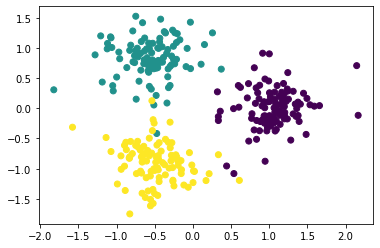

In [9]:
plt.scatter(Y[:,0],Y[:,1],c=true_labels)

In [10]:
def get_spectral_decomposition(A,k):
    if (A<0).any():
        A = pairwise_kernels(A,metric='rbf')
    U = SpectralEmbedding(n_components=k,affinity="precomputed").fit_transform(A)
    return U
def spectral(A,k):
    U = get_spectral_decomposition(A,k)
    return GaussianMixture(n_components=k).fit_predict(U.real)
pred_labels = spectral(X.copy(),c)
print(adjusted_rand_score(true_labels, pred_labels),normalized_mutual_info_score(true_labels, pred_labels))

1.0 1.0


In [11]:
pred_labels = GaussianMixture(n_components=c).fit_predict(Y.copy())
print(adjusted_rand_score(true_labels, pred_labels),normalized_mutual_info_score(true_labels, pred_labels))

0.9601360446191876 0.9362058974566217


In [12]:
model = torchBreg(n_clusters=c,normalize_=True,thresholding=True)
model.fit(A, Y)
z_pred_both = model.predict(A,Y)
print(adjusted_rand_score(true_labels, z_pred_both),normalized_mutual_info_score(true_labels, z_pred_both))

Initialisation chosen from the graph
0
1.0 1.0


In [13]:
n_average = 1
n = 300
n_clusters = 2
d = 1
sizes = [ n // n_clusters ]*np.ones( n_clusters, dtype = int )

b = 5
pout = b * np.log( n ) / n

a_range = [ 5,7,9,11,13,15 ]
r_range = [ 0,1,2,3,4,5 ]
# a_range = [ 5,7,9]
# r_range = [ 0,1,2]

stats = {"varying":[],"a":[],"r":[],"agreed":[],"ARI_chernoff":[],"ARI_AIC":[],"ARI_ORACLE":[]}

for varying in ["attributes","graph"]:
# varying = 'attributes'
# #varying = 'graph'

    aris_attributes_mean = [ ]
    aris_graph_mean = [ ]
    aris_both_mean = [ ]
    aris_attSBM_mean = [ ]
    aris_IR_sLS_mean = [ ]
    aris_IR_LS_mean = [ ]
    aris_both2_mean = [ ]
    aris_oracle_mean = [ ]

    aris_attributes_std = [ ]
    aris_graph_std = [ ]
    aris_both_std = [ ]
    aris_attSBM_std = [ ]
    aris_IR_sLS_std = [ ]
    aris_IR_LS_std = [ ]
    aris_both2_std = [ ]
    aris_oracle_std = [ ]

    if varying == 'graph':
        loop = tqdm( range( len( a_range ) ) )
    else:
        loop = tqdm( range( len( r_range ) ) )

    for dummy in loop:
        if varying == 'graph':
            a = a_range[ dummy ]
            r = 1
        elif varying == 'attributes':
            a = 8
            r = r_range[ dummy ]
        mu = np.array([ [r], [-r] ])
        #print(mu.shape)
        #mu = unitRootCoordinates( d=2, r=r )

        pin = a * np.log( n ) / n
        p = (pin- pout) * np.eye( n_clusters ) + pout * np.ones( (n_clusters, n_clusters) )

        aris_attributes = [ ]
        aris_graph = [ ]
        aris_both = [ ]
        aris_attSBM = [ ]
        aris_IR_sLS  = [ ]
        aris_IR_LS = [ ]
        aris_both2 = [ ]
        aris_oracle = [ ]
        
        path_ = path+f"a/{a}/r/{r}/"
        if not os.path.exists(path_):
            os.makedirs(path_)

        total = 0
        for trial in range( n_average ):
            ( X, Y, z_true ) = generateData( sizes, p, mu )
            model = models.BregmanNodeAttributeGraphClustering( n_clusters = n_clusters, initializer="chernoff")
            ## For comparison purposes, the initialization is the same for IR-sLS, IR-LS and ours    
            model.initialize(X,Y)
            model.assignInitialLabels( X, Y )
            z_init = model.predicted_memberships
            chernoff_init_graph = model.graph_init
            chernoff_graph_labels = model.memberships_from_graph
            chernoff_att_labels = model.memberships_from_attributes

            with open(f'{path_}att_{trial}.npy', 'wb') as g:
                np.save(g, Y)
            with open(f'{path_}net_{trial}.npy', 'wb') as g:
                np.save(g, X)
            with open(f'{path_}z_init_{trial}.npy', 'wb') as g:
                np.save(g, convertZ(z_init)+1)

            model.fit( X, Y )
            z_pred_both = model.predict( X, Y )
            z_pred_graph = models.frommembershipMatriceToVector( chernoff_graph_labels )
            z_pred_attributes = models.frommembershipMatriceToVector( chernoff_att_labels )
            
            if chernoff_init_graph == model.AIC_initializer(X,Y).graph_init:
                total += 1
            
            ## Warm start
            if model.graph_init:
                model.fit( X, Y, chernoff_graph_labels)
            else:
                model.fit(X, Y, chernoff_att_labels)
            
            model2 = torchBreg(n_clusters=n_clusters, normalize_=True, thresholding=True)
            z_pred_both2 = model2.fit(X,Y).predict( X, Y )
            
            IR_sLS_pred = iter_csbm(X,Y,z_init,n_clusters)
            IR_LS_pred = iter_csbm2(X,Y,z_init,n_clusters)
                
            # subprocess.call(["/usr/bin/Rscript","--vanilla","./run_AttSBM.r",\
            #                 f'{path_}att_{trial}.npy',\
            #                 f'{path_}net_{trial}.npy',\
            #                 f'{path_}z_init_{trial}.npy'])
            r_code = f"""
            source("run_AttSBM.r")
            run_AttSBM({path_}att_{trial}.npy,{path_}net_{trial}.npy,{path_}z_init_{trial}.npy)"""
            print(r_code)
            robjects.r(r_code)

            attSBMPred = np.load("predict.npy")

            aris_attributes.append( adjusted_rand_score( z_true, z_pred_attributes ) )
            aris_graph.append( adjusted_rand_score( z_true, z_pred_graph ) )
            aris_both.append( adjusted_rand_score( z_true, z_pred_both ) )
            aris_attSBM.append( adjusted_rand_score( z_true, attSBMPred ) )
            aris_IR_sLS.append( adjusted_rand_score( z_true, IR_sLS_pred ) )
            aris_IR_LS.append( adjusted_rand_score( z_true, IR_LS_pred ) )
            aris_both2.append( adjusted_rand_score( z_true, z_pred_both2 ))
            
            if chernoff_init_graph != model.AIC_initializer(X,Y).graph_init:
                ## both initializations were done
                aris_oracle.append( max(aris_both[-1],aris_both2[-1]))
            elif chernoff_init_graph:
                z_pred_att_init = model.fit(X,Y,chernoff_att_labels).predict(X,Y)
                ari_att_init = adjusted_rand_score( z_true, z_pred_att_init)
                aris_oracle.append( max(aris_both[-1], ari_att_init))
            elif not chernoff_init_graph:
                z_pred_graph_init = model.fit(X,Y,chernoff_graph_labels).predict(X,Y)
                ari_graph_init = adjusted_rand_score( z_true, z_pred_graph_init)
                aris_oracle.append( max(aris_both[-1], ari_graph_init))
                
        aris_attributes_mean.append( np.mean( aris_attributes ) )
        aris_graph_mean.append( np.mean( aris_graph ) )
        aris_both_mean.append( np.mean( aris_both ) )
        aris_attSBM_mean.append( np.mean( aris_attSBM ) )
        aris_IR_sLS_mean.append( np.mean( aris_IR_sLS ) )
        aris_IR_LS_mean.append( np.mean( aris_IR_LS ) )
        aris_both2_mean.append( np.mean( aris_both2) )
        aris_oracle_mean.append( np.mean( aris_oracle) )
        
        aris_attributes_std.append( np.std( aris_attributes ) )
        aris_graph_std.append( np.std( aris_graph ) )
        aris_both_std.append( np.std( aris_both ) )
        aris_attSBM_std.append( np.std( aris_attSBM ) )
        aris_IR_sLS_std.append( np.std( aris_IR_sLS ) )
        aris_IR_LS_std.append( np.std( aris_IR_LS ) )
        aris_both2_std.append( np.std( aris_both2 ) )
        aris_oracle_std.append( np.std( aris_oracle) )
        
        stats["varying"].append(varying)
        stats["a"].append(a)
        stats["r"].append(r)
        stats["agreed"].append(total/n_average)
        stats["ARI_chernoff"].append(aris_both_mean[-1])
        stats["ARI_AIC"].append(aris_both2_mean[-1])
        stats["ARI_ORACLE"].append(aris_oracle_mean[-1])
        
    curves = [ aris_attributes_mean, aris_graph_mean,\
              aris_both_mean , aris_attSBM_mean, aris_IR_sLS_mean,\
              aris_IR_LS_mean, aris_both2_mean]

    curves_std = [ aris_attributes_std, aris_graph_std,\
                  aris_both_std , aris_attSBM_std, aris_IR_sLS_std,\
                  aris_IR_LS_std, aris_both2_std]

    labels = [ 'attributes', 'graph', 'both' , 'attSBM', 'IR_sLS', 'IR_LS', "both2"]
    saveFig = True
    if varying == 'graph':    
        fileName = 'N_' + str(n) + '_K_' + str(n_clusters) + '_b_' + str(b) + '_r_' + str(r) +  '_nAverage' + str(n_average) + '.eps'
        plotting( a_range, curves, labels, curves_std = curves_std, xticks = a_range, xlabel = 'a', saveFig = saveFig, fileName = fileName )
        plt.close()
    elif varying == 'attributes':
        fileName = 'N_' + str(n) + '_K_' + str(n_clusters) + '_a_' + str(a) + '_b_' + str(b) +  '_nAverage_' + str(n_average) + '.eps'
        plotting( r_range, curves, labels, curves_std = curves_std, xticks = r_range, xlabel = 'r', saveFig = saveFig, fileName = fileName )
        plt.close()

  0%|          | 0/6 [00:00<?, ?it/s]

Initialisation chosen from the graph
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen from the graph
number of iterations :  25
Initialisation chosen from the graph
0
1

            source("run_AttSBM.r")
            run_AttSBM(./data/Benchmark/a/8/r/0/att_0.npy,./data/Benchmark/a/8/r/0/net_0.npy,./data/Benchmark/a/8/r/0/z_init_0.npy)

    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

R[write to console]: Error in file(filename, "r", encoding = encoding) : 
  cannot open the connection

R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: package 'reticulate' was built under R version 4.2.3 

R[write to console]: 2: 
R[write to console]: In file(filename, "r", encoding = encoding) :
R[write to console]: 
 
R[write to console]:  cannot open file '../AttributedSBM/FitAttribute.R': No such file or directory

  0%|          | 0/6 [00:06<?, ?it/s]


RRuntimeError: Error in file(filename, "r", encoding = encoding) : 
  cannot open the connection


In [ ]:
import pandas as pd
df = pd.DataFrame.from_dict(stats)

In [ ]:
df